# Check for broken URLs

A WebMap is a collection of layers, basemaps, and other services. These services are hosted on either ArcGIS Online or an external ArcGIS Server, separate from the WebMap itself. If the external service gets deleted, the WebMap will still exist, but it will not function properly.

This notebook will search through all WebMaps in specified groups, and will attempt to connect to each layer URL, basemap URL, etc. If the connection fails for any URL, the owner of the WebMap and other specified users will be notified. This notebook can be used to automatically identify broken WebMaps, and alert the necessary users so they can take the appropriate action.

To get started, import the necessary libraries and connect to our GIS:

In [1]:
import csv
import smtplib
import requests
import logging
log = logging.getLogger()

from IPython.display import display, HTML

from arcgis.gis import GIS
from arcgis.mapping import WebMap

def send_email_smtp(recipients, message, subject=""):
    pass

gis = GIS(username="DavidJVitale")

Enter password: ········


In [2]:
# Set to `True` you would like to check ALL items in an Org
CHECK_ALL_ITEMS = True
# If `CHECK_ALL_ITEMS` is `False`, will check all items in these groups
CHECK_THESE_GROUPS = ['group_name_1', 'group_name_2']

In [3]:
# If you try to email the author of the WebMap of the Broken URLs
TRY_EMAIL_WEBMAP_OWNER = False
# Email these additional people about any broken URLs
EMAIL_THESE_ADDITIONAL_PEOPLE = []

## WebMap Parsing Logic

A core component of this notebook will be testing if different URLs are 'reachable'. We will do this by creating a helper function that uses the `requests` library to make an HTTP GET request to the specified url and assert that is returns a good HTTP status code.

In [4]:
def is_url_reachable(url):
    """Returns a bool representing if the URL is reachable"""
    try:
        response = requests.get(url)
        return response.ok
    except Exception as e:
        return False

Test out this helper function by passing in strings such as `"https://arcgis.com"` or `"https://arcgis.com/nonexistantpage.html"`.

Now, we can create a function that will test the URLs of all operational layers and basemap layers of a WebMap. This function will return a tuple of reachable and unreachable layers.

In [5]:
def test_urls_in_webmap(webmap_item):
    """Takes in an `Item` class instance of a Web Map Item.
    Tests if all operational layers and basemap layers are
    reachable. Returns a tuple of (reachable, unreachable), 
    with each tuple entry being a list of layers/basemaps JSON.
    """
    reachable = []
    unreachable = []
    wm = WebMap(webmap_item)

    # Concatanate all operational layers and basemap layers to 1 list
    all_layers = list(wm.layers)
    if hasattr(wm.basemap, 'baseMapLayers'):
        all_layers += wm.basemap.baseMapLayers

    # Test all of the layers, return the results
    for layer in [layer for layer in all_layers \
                  if hasattr(layer, 'url')]:
        if is_url_reachable(layer.url):
            log.debug(f"    [✓] url {layer.url} reachable")
            reachable.append(layer)
        else:
            log.debug(f"    [X] url {layer.url} NOT reachable")
            unreachable.append(layer)
    return (reachable, unreachable)

Test out this function by passing in an `Item` class instance of a Web Map Item.

Now, let's create a helper function that assembles a human readable string with information about the WebMap, what URLs aren't reachable, etc. We will use this when sending out emails.

In [6]:
def assemble_message(webmap_item, reachable, unreachable):
    """Makes a human readable message with the args passed in"""
    def _assemble_bullet_point(layer, is_reachable):
        """Internal function to assemble one bullet point from a layer"""
        icon = '✅' if is_reachable else '❌'
        return f"* {icon} {layer.id}"

    # Assemble a string representation of both lists
    reachable_str = "\n".join(_assemble_bullet_point(layer, True) \
                               for layer in reachable)
    unreachable_str = "\n".join(_assemble_bullet_point(layer, False) \
                               for layer in unreachable)

    # Asemble the message and return it
    return f"Webmap ID '{webmap_item.id}' contains unreachable URLs. "\
           f"You can view the webmap here: {webmap_item.homepage}\n"\
           f"\n"\
           f"Reachable Layers\n"\
           f"-----------------\n"\
           f"{reachable_str}\n"\
           f"\n"\
           f"Unreachable Layers\n"\
           f"-------------------\n"\
           f"{unreachable_str}"

Now, let's create the function that will be called whenever we encounter a WebMap with broken URLs. This function will assemble the appropriate people to email, assemble the message/subject to send, then send the message to the recipients.

In [7]:
def handle_unreachable(webmap_item, reachable, unreachable,
                        gis=gis):
    """Called whenever we encounter a WebMap with broken URLs. Will 
    assemble an appropriate message, and send it out to the previously
    configured emails.
    """
    display(HTML("<h3>THIS ITEM CONTAINS UNREACHABLE URLS:</h3>"))
    display(webmap_item)

> __Note__: If you have an alternative notification function you want to use, make sure you modify the above cell to include that function.

Now, let's create a generator function that will `yield` `Item`(s). This notebook can run against all items in an Organization, or all items from certain groups, depending on how you configured the notebook above.

In [8]:
def get_items_to_check():
    """Generator function that will yield Items depending on how you
    configured your notebook. Will either yield every item in an 
    organization, or will yield items in specific groups.
    """
    for item in gis.users.me.items(max_items=999999999):
        # For the user's root folder
        yield item
    for folder in gis.users.me.folders:
        # For all the user's other folders
        for item in gis.users.me.items(folder, max_items=999999999):
            yield item

## main()

Finally, let's create our `main()` function that links together all our previously defined functions to search through groups, test all webmaps for broken URLs, and alert the correct people when we find unreachable URLs.

In [9]:
def main():
    print("Notebook is now running, please wait...\n-----")
    for item in get_items_to_check():
        print(f"\rChecking item {item.id}", end="")
        if item.type == "Web Map":
            reachable, unreachable = test_urls_in_webmap(item)
            if unreachable:
                print(f"\nWebmap {item.id} unreachable. Notifying...")
                handle_unreachable(item, reachable, unreachable)
    print("-----\nNotebook completed running.")

In [23]:
main()

Notebook is now running, please wait...
-----
Checking item 222707e6e0c345f899b86fadb61ff4ad-----
Notebook completed running.


<Item title:"My Webmap from the old portal" type:Web Map owner:DavidJVitale>
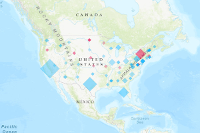

In [11]:
wm_item = gis.content.get('7b370691501d4c27b0e755458c916057')
wm_item

In [12]:
data = wm_item.get_data()
data

{'operationalLayers': [{'id': 'USA_Daytime_Population_2016_763',
   'layerType': 'ArcGISFeatureLayer',
   'url': 'https://services.arcgis.com/jIL9msH9OI208GCb/arcgis/rest/services/USA_Daytime_Population_2016/FeatureServer/2',
   'visibility': True,
   'opacity': 1,
   'title': 'USA 2016 Daytime Population - Tracts',
   'itemId': 'f01f0eda766344e29f42031e7bfb7d04'},
  {'id': 'USA_Daytime_Population_2016_7562',
   'layerType': 'ArcGISFeatureLayer',
   'url': 'https://my-old-portal.nonexistantwebsite3112020.com/arcgis/rest/services/USA_Daytime_Population_2016/FeatureServer/1',
   'visibility': True,
   'opacity': 1,
   'title': 'USA 2016 Daytime Population - Counties',
   'itemId': 'f01f0eda766344e29f42031e7bfb7d04'},
  {'id': 'USA_Daytime_Population_2016_3919',
   'layerType': 'ArcGISFeatureLayer',
   'url': 'https://services.arcgis.com/jIL9msH9OI208GCb/arcgis/rest/services/USA_Daytime_Population_2016/FeatureServer/0',
   'visibility': True,
   'opacity': 1,
   'title': 'USA 2016 Daytime

In [15]:
data['operationalLayers'][1]

{'id': 'USA_Daytime_Population_2016_7562',
 'layerType': 'ArcGISFeatureLayer',
 'url': 'https://my-old-portal.nonexistantwebsite3112020.com/arcgis/rest/services/USA_Daytime_Population_2016/FeatureServer/1',
 'visibility': True,
 'opacity': 1,
 'title': 'USA 2016 Daytime Population - Counties',
 'itemId': 'f01f0eda766344e29f42031e7bfb7d04'}

In [16]:
data['operationalLayers'][1]['url'] = \
    "https://services.arcgis.com/jIL9msH9OI208GCb/arcgis/rest/services/USA_Daytime_Population_2016/FeatureServer/1"

In [17]:
data['operationalLayers'][1]

{'id': 'USA_Daytime_Population_2016_7562',
 'layerType': 'ArcGISFeatureLayer',
 'url': 'https://services.arcgis.com/jIL9msH9OI208GCb/arcgis/rest/services/USA_Daytime_Population_2016/FeatureServer/1',
 'visibility': True,
 'opacity': 1,
 'title': 'USA 2016 Daytime Population - Counties',
 'itemId': 'f01f0eda766344e29f42031e7bfb7d04'}

In [20]:
wm_item.update({'text' : data})

True